In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')


In [ ]:

CONFIG = {
    'data_root': '/content/drive/MyDrive/Rajasthan_Landmark_dataset/Rajasthan_Landmark_dataset',
    'batch_size': 32,
    'num_epochs': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'image_size': 224,
    'num_workers': 32,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'pretrained': True,
    'dropout': 0.35,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.2,
    'test_size': 0.15,
    'val_size': 0.15,
    'model_name': 'hybrid_vit_resnet50',
}

# ============================================
# GPU CHECK
# ============================================
def check_gpu_availability():
    print("="*60)
    print("GPU/CPU CHECK - GOOGLE COLAB")
    print("="*60)
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"✅ CUDA version: {torch.version.cuda}")
        print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
        return 'cuda'
    else:
        print("⚠️  Please enable GPU: Runtime > Change runtime type > GPU")
        return 'cpu'

# ============================================
# DATASET LOADER
# ============================================
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
        except:
            img = Image.new('RGB', (224, 224), color='black')
        if self.transform:
            img = self.transform(img)
        return img, label

def load_dataset(root):
    image_paths, labels = [], []
    label_map = {}
    idx_map = {}
    i = 0
    for city in os.listdir(root):
        city_path = os.path.join(root, city)
        if not os.path.isdir(city_path):
            continue
        for landmark in os.listdir(city_path):
            landmark_path = os.path.join(city_path, landmark)
            if not os.path.isdir(landmark_path):
                continue
            if landmark not in label_map:
                label_map[landmark] = i
                idx_map[i] = landmark
                i += 1
            for img in os.listdir(landmark_path):
                if img.lower().endswith(('jpg','jpeg','png','webp')):
                    image_paths.append(os.path.join(landmark_path, img))
                    labels.append(label_map[landmark])
    return image_paths, labels, label_map, idx_map

def get_transforms(train=False, size=224):
    if train:
        return transforms.Compose([
            transforms.Resize((size+32, size+32)),
            transforms.RandomCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.33)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

# ============================================
# MIXUP AUGMENTATION
# ============================================
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ============================================
# HYBRID MODEL (CNN + ViT)
# ============================================
class HybridViTModel(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout=0.4):
        super().__init__()
        # CNN backbone for local features
        self.cnn_backbone = timm.create_model('resnet50', pretrained=pretrained, features_only=True)
        cnn_channels = self.cnn_backbone.feature_info[-1]['num_chs']  # usually 2048

        # ViT head for global context
        self.vit_head = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=0  # feature extractor only
        )

        # Projection for CNN features to ViT-compatible embedding
        self.proj = nn.Conv2d(cnn_channels, 768, kernel_size=1)

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(1536, num_classes)

    def forward(self, x):
        # CNN backbone (fine-grained features)
        cnn_feats = self.cnn_backbone(x)[-1]   # [B, 2048, H/32, W/32]
        proj_feats = self.proj(cnn_feats)      # [B, 768, H/32, W/32]
        cnn_global = proj_feats.mean(dim=[2, 3])  # Global average pooling -> [B, 768]

        # ViT head (global context)
        vit_out = self.vit_head.forward_features(x)  # [B, 197, 768] or [B, 768]
        if vit_out.dim() == 3:  # Some ViTs output tokens
            vit_global = vit_out[:, 0, :]  # CLS token
        else:
            vit_global = vit_out

        # Combine local (CNN) + global (ViT) features
        fused = torch.cat((vit_global, cnn_global), dim=1)  # [B, 1536]

        out = self.dropout(fused)
        logits = self.fc(out)
        return logits

# ============================================
# TRAINING / VALIDATION FUNCTIONS
# ============================================
def train_epoch(model, loader, criterion, optimizer, device, mixup_alpha=0.2):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader, desc='Training'):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        if np.random.rand() < 0.5:
            mixed_x, y_a, y_b, lam = mixup_data(imgs, labels, mixup_alpha)
            outputs = model(mixed_x)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return total_loss/len(loader), 100*correct/total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc='Validating'):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = 100*correct/total
    return total_loss/len(loader), acc, all_preds, all_labels

# ============================================
# MAIN FUNCTION
# ============================================
def main():
    CONFIG['device'] = check_gpu_availability()
    device = CONFIG['device']

    print("\nLoading dataset...")
    image_paths, labels, class_map, idx_map = load_dataset(CONFIG['data_root'])
    num_classes = len(class_map)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, test_size=CONFIG['test_size'] + CONFIG['val_size'], random_state=42
    )
    val_rel_size = CONFIG['val_size'] / (CONFIG['test_size'] + CONFIG['val_size'])
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1 - val_rel_size, random_state=42
    )

    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    train_ds = LandmarkDataset(X_train, y_train, transform=get_transforms(True, CONFIG['image_size']))
    val_ds = LandmarkDataset(X_val, y_val, transform=get_transforms(False, CONFIG['image_size']))
    test_ds = LandmarkDataset(X_test, y_test, transform=get_transforms(False, CONFIG['image_size']))

    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    print("\nCreating Hybrid ViT model...")
    model = HybridViTModel(num_classes=num_classes, pretrained=True, dropout=CONFIG['dropout']).to(device)
    print(f"✅ Model created with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")

    criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['num_epochs'], eta_min=1e-6)

    best_val_acc = 0
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        print("-"*60)
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, CONFIG['mixup_alpha'])
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'class_map': class_map,
                'idx_map': idx_map,
                'config': CONFIG
            }, '/content/best_hybrid_landmark_model.pth')
            print(f"✅ Saved new best model (Val Acc: {val_acc:.2f}%)")

    print("\nEvaluating on test set...")
    checkpoint = torch.load('/content/best_hybrid_landmark_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_acc, preds, labels_true = validate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

    print("\nClassification Report:")
    print(classification_report(labels_true, preds, target_names=[idx_map[i] for i in range(num_classes)]))

    results = {
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'num_classes': num_classes
    }
    with open('/content/hybrid_training_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    print("\n✅ Training complete!")
    print("Model saved as: /content/best_hybrid_landmark_model.pth")
    print("Results saved as: /content/hybrid_training_results.json")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU/CPU CHECK - GOOGLE COLAB
PyTorch version: 2.8.0+cu126
CUDA available: True
✅ CUDA version: 12.6
✅ GPU: Tesla T4

Loading dataset...
Train: 5477 | Val: 1174 | Test: 1174

Creating Hybrid ViT model...


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Model created with 110.96M parameters

Epoch 1/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:31<00:00,  1.19it/s]


Train Loss: 2.2057 | Acc: 46.56%
Val Loss: 0.9945 | Acc: 94.12%
✅ Saved new best model (Val Acc: 94.12%)

Epoch 2/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.50it/s]


Train Loss: 1.1822 | Acc: 68.60%
Val Loss: 0.8647 | Acc: 97.44%
✅ Saved new best model (Val Acc: 97.44%)

Epoch 3/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.50it/s]


Train Loss: 1.0238 | Acc: 71.75%
Val Loss: 0.7778 | Acc: 98.89%
✅ Saved new best model (Val Acc: 98.89%)

Epoch 4/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.50it/s]


Train Loss: 1.0285 | Acc: 69.42%
Val Loss: 0.7884 | Acc: 98.30%

Epoch 5/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]


Train Loss: 1.0335 | Acc: 73.22%
Val Loss: 0.8023 | Acc: 97.87%

Epoch 6/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.48it/s]


Train Loss: 1.0337 | Acc: 75.70%
Val Loss: 0.7855 | Acc: 98.38%

Epoch 7/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.49it/s]


Train Loss: 1.0195 | Acc: 74.77%
Val Loss: 0.7635 | Acc: 98.55%

Epoch 8/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]


Train Loss: 0.9346 | Acc: 79.62%
Val Loss: 0.7531 | Acc: 99.15%
✅ Saved new best model (Val Acc: 99.15%)

Epoch 9/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.49it/s]


Train Loss: 0.9407 | Acc: 73.31%
Val Loss: 0.7631 | Acc: 98.81%

Epoch 10/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.47it/s]


Train Loss: 0.9537 | Acc: 79.40%
Val Loss: 0.7535 | Acc: 99.06%

Epoch 11/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Train Loss: 0.9503 | Acc: 73.32%
Val Loss: 0.7617 | Acc: 98.38%

Epoch 12/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.47it/s]


Train Loss: 0.9431 | Acc: 74.06%
Val Loss: 0.7373 | Acc: 99.23%
✅ Saved new best model (Val Acc: 99.23%)

Epoch 13/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Train Loss: 0.9012 | Acc: 78.35%
Val Loss: 0.7543 | Acc: 98.72%

Epoch 14/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.46it/s]


Train Loss: 0.9936 | Acc: 69.38%
Val Loss: 0.7470 | Acc: 99.23%

Epoch 15/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.48it/s]


Train Loss: 0.8972 | Acc: 72.56%
Val Loss: 0.7477 | Acc: 98.98%

Epoch 16/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.46it/s]


Train Loss: 0.8969 | Acc: 75.94%
Val Loss: 0.7437 | Acc: 99.06%

Epoch 17/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


Train Loss: 0.8932 | Acc: 77.36%
Val Loss: 0.7386 | Acc: 99.15%

Epoch 18/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s]


Train Loss: 0.8866 | Acc: 76.23%
Val Loss: 0.7354 | Acc: 99.15%

Epoch 19/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s]


Train Loss: 0.8579 | Acc: 82.58%
Val Loss: 0.7321 | Acc: 99.23%

Epoch 20/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.47it/s]


Train Loss: 0.8344 | Acc: 74.66%
Val Loss: 0.7346 | Acc: 98.89%

Epoch 21/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


Train Loss: 0.8988 | Acc: 79.86%
Val Loss: 0.7310 | Acc: 99.06%

Epoch 22/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Train Loss: 0.8637 | Acc: 80.26%
Val Loss: 0.7325 | Acc: 99.15%

Epoch 23/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


Train Loss: 0.9029 | Acc: 75.02%
Val Loss: 0.7300 | Acc: 99.06%

Epoch 24/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.50it/s]


Train Loss: 0.8452 | Acc: 73.89%
Val Loss: 0.7287 | Acc: 99.23%

Epoch 25/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Train Loss: 0.8726 | Acc: 65.44%
Val Loss: 0.7272 | Acc: 99.06%

Epoch 26/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


Train Loss: 0.8727 | Acc: 73.49%
Val Loss: 0.7273 | Acc: 98.98%

Epoch 27/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


Train Loss: 0.8828 | Acc: 76.30%
Val Loss: 0.7275 | Acc: 99.23%

Epoch 28/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]


Train Loss: 0.8769 | Acc: 76.98%
Val Loss: 0.7251 | Acc: 99.32%
✅ Saved new best model (Val Acc: 99.32%)

Epoch 29/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]


Train Loss: 0.8446 | Acc: 79.46%
Val Loss: 0.7243 | Acc: 99.40%
✅ Saved new best model (Val Acc: 99.40%)

Epoch 30/30
------------------------------------------------------------


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


Train Loss: 0.8523 | Acc: 77.29%
Val Loss: 0.7248 | Acc: 99.40%

Evaluating on test set...


Validating: 100%|██████████| 37/37 [00:31<00:00,  1.16it/s]


Test Loss: 0.7230 | Test Accuracy: 99.40%

Classification Report:
                              precision    recall  f1-score   support

                umaid_bhawan       1.00      1.00      1.00        41
               Jaswant Thada       1.00      1.00      1.00        26
       Ghanta Ghar (Jodhpur)       1.00      1.00      1.00        28
             mehrangarh_fort       1.00      1.00      1.00        39
                 Lake Palace       1.00      1.00      1.00        24
              Monsoon Palace       1.00      1.00      1.00        29
        City Palace, Udaipur       1.00      1.00      1.00        30
              Jagdish Temple       1.00      1.00      1.00        36
           Jag Mandir Palace       1.00      0.96      0.98        23
              Rajsamand Lake       1.00      1.00      1.00        31
            Kumbhalgarh fort       1.00      0.92      0.96        25
             Hadi rani baori       1.00      1.00      1.00        31
               SUNEHRI

In [ ]:
# Quick download script
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Copy files to Drive
model_src = '/content/best_hybrid_landmark_model.pth'
results_src = '/content/hybrid_training_results.json'

if os.path.exists(model_src):
    drive_model = '/content/drive/MyDrive/best_hybrid_landmark_model.pth'
    shutil.copy(model_src, drive_model)
    size_mb = os.path.getsize(drive_model) / (1024 * 1024)
    print(f"✅ Model saved to Google Drive ({size_mb:.2f} MB)")
    print(f"   Path: {drive_model}")
else:
    print("❌ Model file not found!")

if os.path.exists(results_src):
    drive_results = '/content/drive/MyDrive/training_results.json'
    shutil.copy(results_src, drive_results)
    print(f"✅ Results saved to Google Drive")
    print(f"   Path: {drive_results}")

print("\n📥 Now download from Google Drive:")
print("   1. Open drive.google.com")
print("   2. Find 'best_hybrid_landmark_model.pth' in 'My Drive'")
print("   3. Right-click > Download")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to Google Drive (423.64 MB)
   Path: /content/drive/MyDrive/best_hybrid_landmark_model.pth
✅ Results saved to Google Drive
   Path: /content/drive/MyDrive/training_results.json

📥 Now download from Google Drive:
   1. Open drive.google.com
   2. Find 'best_hybrid_landmark_model.pth' in 'My Drive'
   3. Right-click > Download


HYBRID LANDMARK DETECTION - MODEL TESTING
🔄 Loading model from /content/drive/MyDrive/best_hybrid_landmark_model.pth...
✅ Model loaded successfully on cuda
Classes: 49

TESTING OPTIONS
1️⃣ Upload an image
2️⃣ Test random dataset image
3️⃣ Test from URL
Enter choice (1/2/3): 1

📤 Upload an image to test...


Saving jaipur test 3.jpg to jaipur test 3.jpg


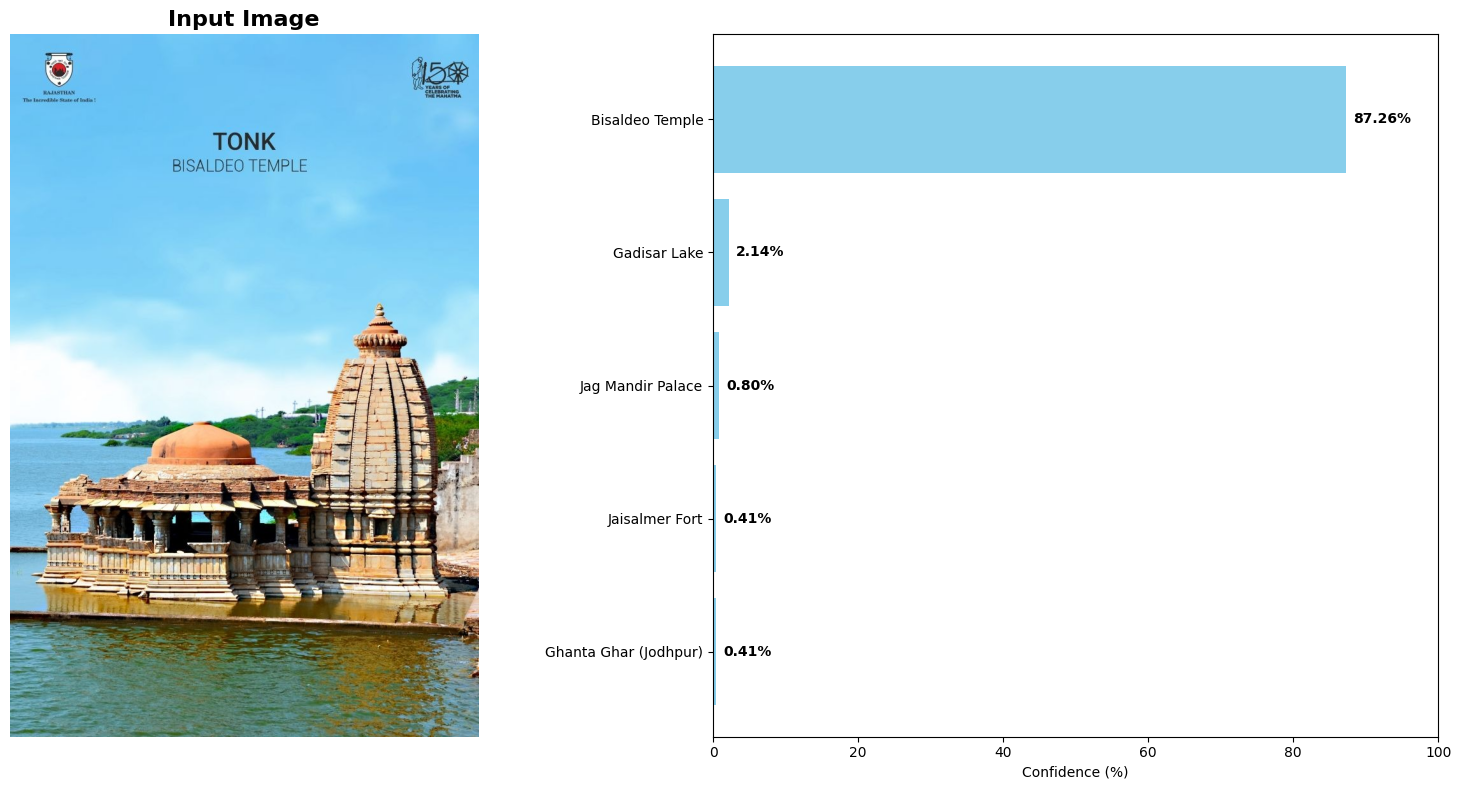


🎯 Top Prediction: Bisaldeo Temple (87.26%)

📊 Top 5 Predictions:
1. Bisaldeo Temple: 87.26%
2. Gadisar Lake: 2.14%
3. Jag Mandir Palace: 0.80%
4. Jaisalmer Fort: 0.41%
5. Ghanta Ghar (Jodhpur): 0.41%


In [ ]:
# ============================================
# test_hybrid_vit_model_colab.py
# For testing your trained HybridViTModel in Google Colab
# ============================================

import torch
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os, random, requests, json
from io import BytesIO
from google.colab import files

# ============================================
# HYBRID MODEL DEFINITION (same as training)
# ============================================
class HybridViTModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=False, dropout=0.4):
        super().__init__()
        # CNN backbone (ResNet50)
        self.cnn_backbone = timm.create_model('resnet50', pretrained=pretrained, features_only=True)
        cnn_channels = self.cnn_backbone.feature_info[-1]['num_chs']  # 2048

        # ViT (Base)
        self.vit_head = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=0
        )

        # Projection + Fusion
        self.proj = torch.nn.Conv2d(cnn_channels, 768, kernel_size=1)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(1536, num_classes)

    def forward(self, x):
        # CNN branch (fine detail)
        cnn_feats = self.cnn_backbone(x)[-1]       # [B, 2048, 7, 7]
        proj_feats = self.proj(cnn_feats)          # [B, 768, 7, 7]
        cnn_global = proj_feats.mean(dim=[2, 3])   # [B, 768]

        # ViT branch (context)
        vit_out = self.vit_head.forward_features(x)
        if vit_out.dim() == 3:
            vit_global = vit_out[:, 0, :]          # CLS token
        else:
            vit_global = vit_out                   # [B, 768]

        # Fuse + classify
        fused = torch.cat((vit_global, cnn_global), dim=1)  # [B, 1536]
        out = self.dropout(fused)
        logits = self.fc(out)
        return logits

# ============================================
# IMAGE TRANSFORMS
# ============================================
def get_transforms(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

# ============================================
# LOAD TRAINED MODEL
# ============================================
def load_model(model_path='/content/drive/MyDrive/best_hybrid_landmark_model.pth', device='cuda'):
    print(f"🔄 Loading model from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)

    class_map = checkpoint['class_map']
    idx_map = checkpoint['idx_map']
    num_classes = len(class_map)
    config = checkpoint.get('config', {})
    dropout = config.get('dropout', 0.4)

    model = HybridViTModel(num_classes=num_classes, pretrained=False, dropout=dropout).to(device)
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    model.eval()

    print(f"✅ Model loaded successfully on {device}")
    print(f"Classes: {num_classes}")
    return model, idx_map, class_map

# ============================================
# PREDICTION FUNCTION
# ============================================
def predict_image(model, image_input, idx_map, device='cuda', top_k=5):
    # Handle file path or URL
    if isinstance(image_input, str):
        if image_input.startswith('http'):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_input).convert('RGB')
    else:
        image = image_input.convert('RGB')

    transform = get_transforms()
    tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1)
        top_probs, top_idxs = torch.topk(probs, min(top_k, len(idx_map)))

    preds = [
        {'landmark': idx_map[i.item()], 'confidence': p.item()}
        for p, i in zip(top_probs[0], top_idxs[0])
    ]
    return image, preds

# ============================================
# VISUALIZATION
# ============================================
def visualize_predictions(image, preds, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Show image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Input Image", fontsize=16, fontweight='bold')

    # Predictions
    labels = [p['landmark'] for p in preds]
    confs = [p['confidence'] * 100 for p in preds]
    y = np.arange(len(labels))

    axes[1].barh(y, confs, color='skyblue')
    axes[1].set_yticks(y)
    axes[1].set_yticklabels(labels)
    axes[1].invert_yaxis()
    axes[1].set_xlabel("Confidence (%)")
    axes[1].set_xlim(0, 100)

    for i, c in enumerate(confs):
        axes[1].text(c + 1, i, f"{c:.2f}%", va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print("\n🎯 Top Prediction:", preds[0]['landmark'], f"({preds[0]['confidence']*100:.2f}%)")
    print("\n📊 Top 5 Predictions:")
    for i, p in enumerate(preds, 1):
        print(f"{i}. {p['landmark']}: {p['confidence']*100:.2f}%")

# ============================================
# TESTING OPTIONS
# ============================================
def test_from_upload(model, idx_map, device='cuda'):
    print("\n📤 Upload an image to test...")
    uploaded = files.upload()
    if not uploaded:
        print("❌ No file uploaded!")
        return
    path = list(uploaded.keys())[0]
    img, preds = predict_image(model, path, idx_map, device)
    visualize_predictions(img, preds)

def test_from_dataset(model, idx_map, class_map, device='cuda',
                      data_root='/content/drive/MyDrive/Rajasthan_Landmark_dataset/Rajasthan_Landmark_dataset'):
    print("\n🎲 Selecting random test image...")
    all_images = []
    for city in os.listdir(data_root):
        city_path = os.path.join(data_root, city)
        if not os.path.isdir(city_path): continue
        for landmark in os.listdir(city_path):
            landmark_path = os.path.join(city_path, landmark)
            if not os.path.isdir(landmark_path): continue
            for f in os.listdir(landmark_path):
                if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp')):
                    all_images.append((os.path.join(landmark_path, f), landmark))
    if not all_images:
        print("❌ No images found in dataset!")
        return

    path, label = random.choice(all_images)
    print(f"Image Path: {path}\nTrue Label: {label}")

    img, preds = predict_image(model, path, idx_map, device)
    visualize_predictions(img, preds)

    pred_label = preds[0]['landmark']
    print(f"\n✅ Correct!" if pred_label == label else f"❌ Incorrect. Predicted: {pred_label}")

def test_from_url(model, idx_map, device='cuda'):
    url = input("Enter image URL: ").strip()
    if not url:
        print("❌ No URL provided!")
        return
    img, preds = predict_image(model, url, idx_map, device)
    visualize_predictions(img, preds)

# ============================================
# MAIN EXECUTION
# ============================================
def main():
    print("="*60)
    print("HYBRID LANDMARK DETECTION - MODEL TESTING")
    print("="*60)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_path = '/content/drive/MyDrive/best_hybrid_landmark_model.pth'
    if not os.path.exists(model_path):
        model_path = '/content/drive/MyDrive/best_hybrid_landmark_model.pth'
        if not os.path.exists(model_path):
            print("❌ Model not found! Check path.")
            return

    model, idx_map, class_map = load_model(model_path, device)

    print("\nTESTING OPTIONS")
    print("="*60)
    print("1️⃣ Upload an image")
    print("2️⃣ Test random dataset image")
    print("3️⃣ Test from URL")
    print("="*60)
    choice = input("Enter choice (1/2/3): ").strip()

    if choice == '1':
        test_from_upload(model, idx_map, device)
    elif choice == '2':
        test_from_dataset(model, idx_map, class_map, device)
    elif choice == '3':
        test_from_url(model, idx_map, device)
    else:
        print("Invalid choice!")

if __name__ == "__main__":
    main()
